In [ ]:
### importando pacotes e 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
from darts.metrics import mape,mae,mse
from darts.timeseries import TimeSeries

In [11]:
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis, plot_hist,extract_trend_and_seasonality
from darts.utils.utils import SeasonalityMode
import logging
from darts.utils.utils import ModelMode
from darts.utils.utils import TrendMode
from darts.models import Prophet
from darts.dataprocessing.transformers import Scaler

## EDA

In [12]:
import pickle
with open("../../SRAG_time_series/series_weekly_SRAG.pkl", "rb") as f:
    series_weekly = pickle.load(f)

<Axes: xlabel='Year_Week'>

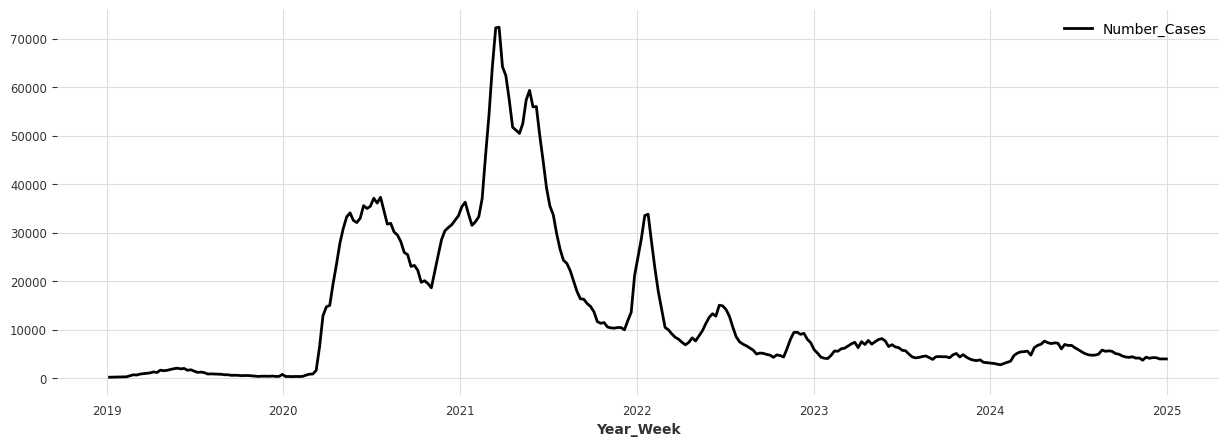

In [13]:
from scipy.stats import fit
from scipy.stats import fit
from scipy.stats import norm, lognorm

fig, ax = plt.subplots(figsize=(15, 5))
series_weekly.plot()

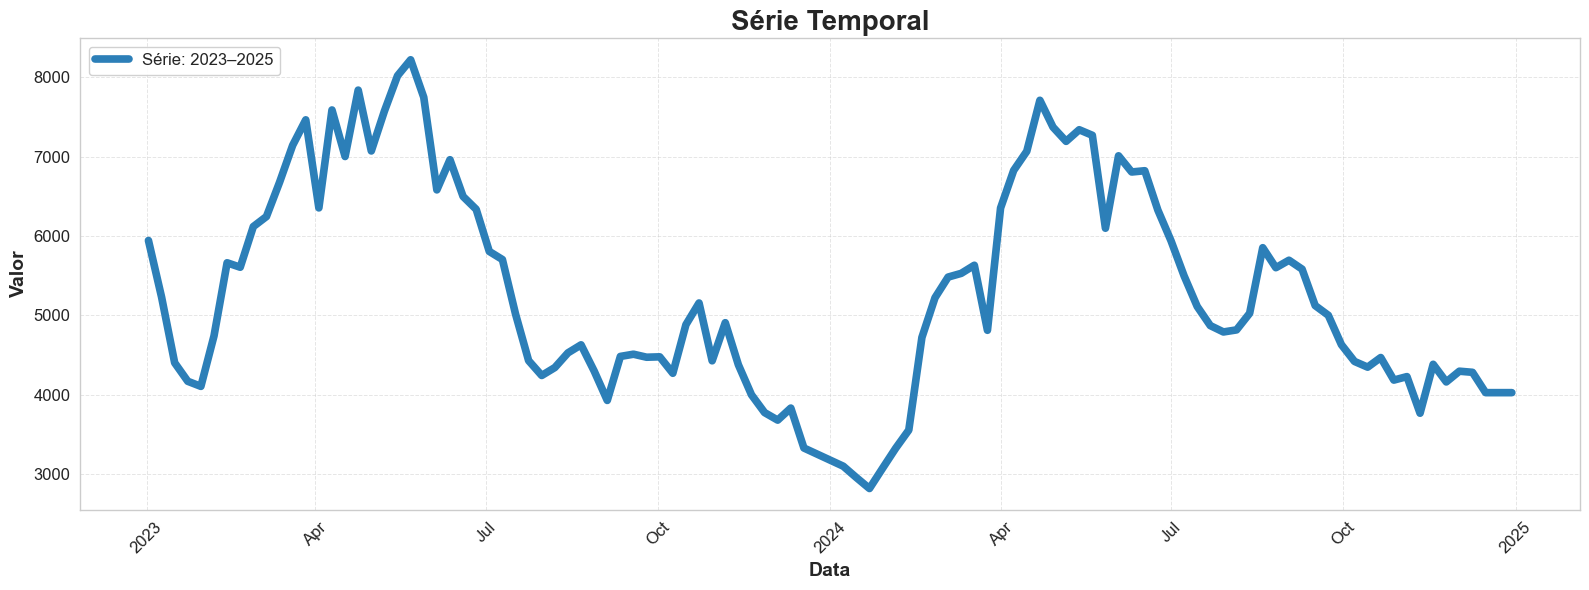

In [46]:
# Selecionar o período desejado
serie_parcial = series_weekly.slice(pd.Timestamp('2023-01-01'), pd.Timestamp('2025-01-01'))

# Criar a figura
plt.figure(figsize=(16, 6))

# Plot da série parcial
serie_parcial.plot(label="Série: 2023–2025", linewidth=5.5, color="#2c7fb8")  # azul elegante

# Título e eixos
plt.title("Série Temporal", fontsize=20, fontweight='bold')
plt.xlabel("Data", fontsize=14)
plt.ylabel("Valor", fontsize=14)

# Estilo dos ticks
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Grade mais suave
plt.grid(True, linestyle="--", linewidth=0.7, alpha=0.5)

# Legenda clara
plt.legend(fontsize=12, loc="upper left", frameon=True, framealpha=0.9)

# Layout final
plt.tight_layout()
plt.show()

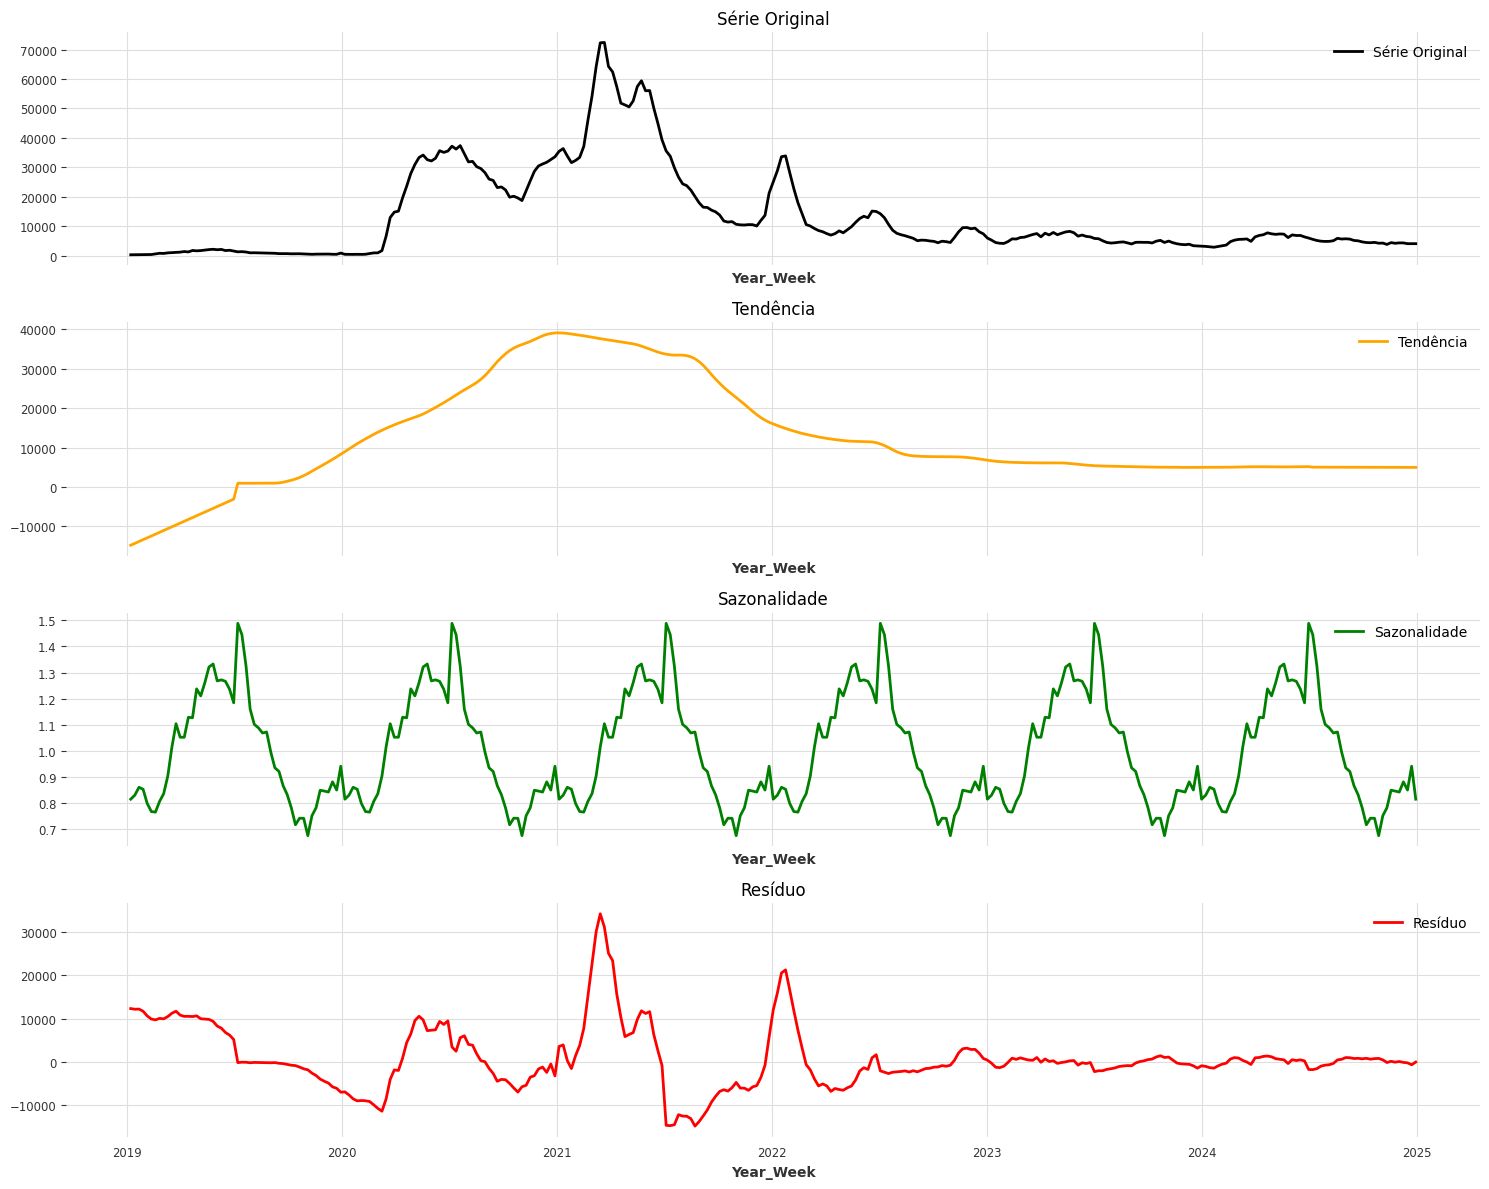

In [14]:
import matplotlib.pyplot as plt

series_trend, series_seasonality = extract_trend_and_seasonality(series_weekly, model=ModelMode.MULTIPLICATIVE)
reconstructed = series_trend * series_seasonality
series_residual = series_weekly - reconstructed

# Criar subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Plot da série original
series_weekly.plot(ax=axes[0], label="Série Original")
axes[0].set_title("Série Original")
axes[0].legend()

# Plot da tendência
series_trend.plot(ax=axes[1], label="Tendência", color="orange")
axes[1].set_title("Tendência")
axes[1].legend()

# Plot da sazonalidade
series_seasonality.plot(ax=axes[2], label="Sazonalidade", color="green")
axes[2].set_title("Sazonalidade")
axes[2].legend()

# Plot do resíduo
series_residual.plot(ax=axes[3], label="Resíduo", color="red")
axes[3].set_title("Resíduo")
axes[3].legend()

# Ajustar o layout
plt.tight_layout()
plt.show()

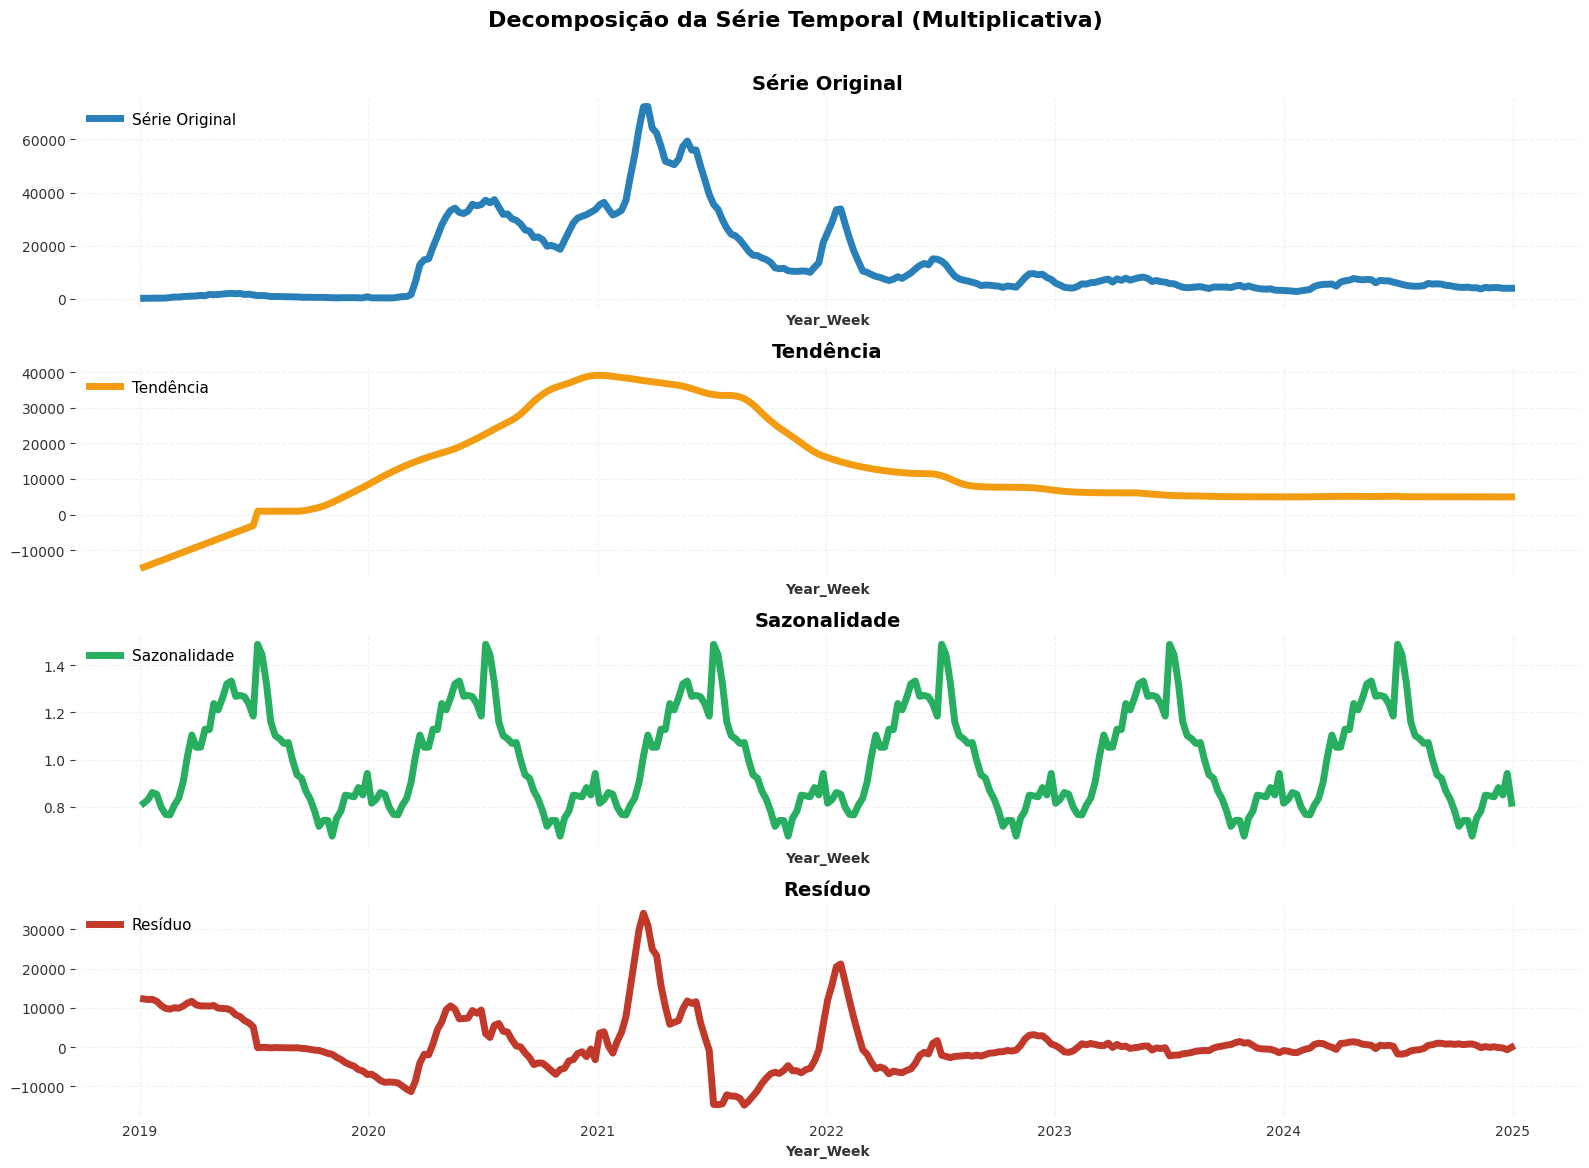

In [20]:
# Decomposição
series_trend, series_seasonality = extract_trend_and_seasonality(series_weekly, model=ModelMode.MULTIPLICATIVE)
reconstructed = series_trend * series_seasonality
series_residual = series_weekly - reconstructed


# Criar subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Paleta de cores modernas
colors = {
    "original": "#2980b9",     # Azul
    "trend": "#f39c12",        # Laranja
    "seasonality": "#27ae60",  # Verde
    "residual": "#c0392b"      # Vermelho
}

# Plot da série original
series_weekly.plot(ax=axes[0], label="Série Original", lw=5, color=colors["original"])
axes[0].set_title("Série Original", fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=11)

# Plot da tendência
series_trend.plot(ax=axes[1], label="Tendência", lw=5, color=colors["trend"])
axes[1].set_title("Tendência", fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=11)

# Plot da sazonalidade
series_seasonality.plot(ax=axes[2], label="Sazonalidade", lw=5, color=colors["seasonality"])
axes[2].set_title("Sazonalidade", fontsize=14, fontweight='bold')
axes[2].legend(loc='upper left', fontsize=11)

# Plot do resíduo
series_residual.plot(ax=axes[3], label="Resíduo", lw=5, color=colors["residual"])
axes[3].set_title("Resíduo", fontsize=14, fontweight='bold')
axes[3].legend(loc='upper left', fontsize=11)

# Eixos e layout
for ax in axes:
    ax.tick_params(labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.4)

# Ajustar espaço entre subplots
plt.suptitle("Decomposição da Série Temporal (Multiplicativa)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.01, 1, 0.97])
plt.show()

## Prophet

In [21]:
# Realizando o split
train, val = series_weekly.split_before(0.83)

### Setup de treinamento utilizando OPTUNA 

In [22]:
from prophet import Prophet  # Facebook's Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error

In [23]:
# For older Darts versions
train_df = pd.DataFrame({
    "ds": train.time_index,  # Gets the datetime index
    "y": train.univariate_values()  # Gets the values
})

val_df = pd.DataFrame({
    "ds": val.time_index,
    "y": val.univariate_values()
})

df = pd.DataFrame({
    "ds": series_weekly.time_index,
    "y": series_weekly.univariate_values()
})

In [24]:
def objective(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 5, 20),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 3, 10),
    }
    
    # Criar e treinar o modelo
    model = Prophet(**params)
    model.fit(train_df)

        # Fazer previsão no conjunto de teste
    future = model.make_future_dataframe(periods=len(val_df))
    forecast = model.predict(future)
    
    # Calcular RMSE
    y_true = val_df['y'].values
    y_pred = forecast.tail(len(val_df))['yhat'].values
    rmse = mean_squared_error(y_true, y_pred)
    
    return rmse


In [25]:
study = optuna.create_study(direction='minimize')  # Queremos minimizar o RMSE
study.optimize(objective, n_trials=50)  # Testar 50 combinações de parâmetros

# Melhores parâmetros encontrados
print("Melhores parâmetros:", study.best_params)

[I 2025-06-06 09:49:42,294] A new study created in memory with name: no-name-4911f8dc-91cd-4f5e-8a62-a7a32add3000
09:49:42 - cmdstanpy - INFO - Chain [1] start processing
09:49:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-06-06 09:49:43,802] Trial 0 finished with value: 17392119.244964387 and parameters: {'changepoint_prior_scale': 0.09553828578026839, 'seasonality_prior_scale': 5.206671320018813, 'holidays_prior_scale': 1.9293092645028886, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 11, 'weekly_seasonality': 7}. Best is trial 0 with value: 17392119.244964387.
09:49:43 - cmdstanpy - INFO - Chain [1] start processing
09:49:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-06-06 09:49:44,362] Trial 1 finished with value: 20806379.101589046 and parameters: {'changepoint_prior_scale': 0.3560206075111871, 'seasonality_prior_scale': 4.829332144320847, 'holidays_prior_scale': 3.679175237848161, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16

Melhores parâmetros: {'changepoint_prior_scale': 0.4964760297188522, 'seasonality_prior_scale': 6.868459996958488, 'holidays_prior_scale': 6.343494438364207, 'seasonality_mode': 'additive', 'yearly_seasonality': 5, 'weekly_seasonality': 3}


In [26]:
best_params = study.best_params

model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=best_params['yearly_seasonality'],
    weekly_seasonality=best_params['weekly_seasonality'],
)

model.fit(df)

09:50:07 - cmdstanpy - INFO - Chain [1] start processing
09:50:07 - cmdstanpy - INFO - Chain [1] done processing


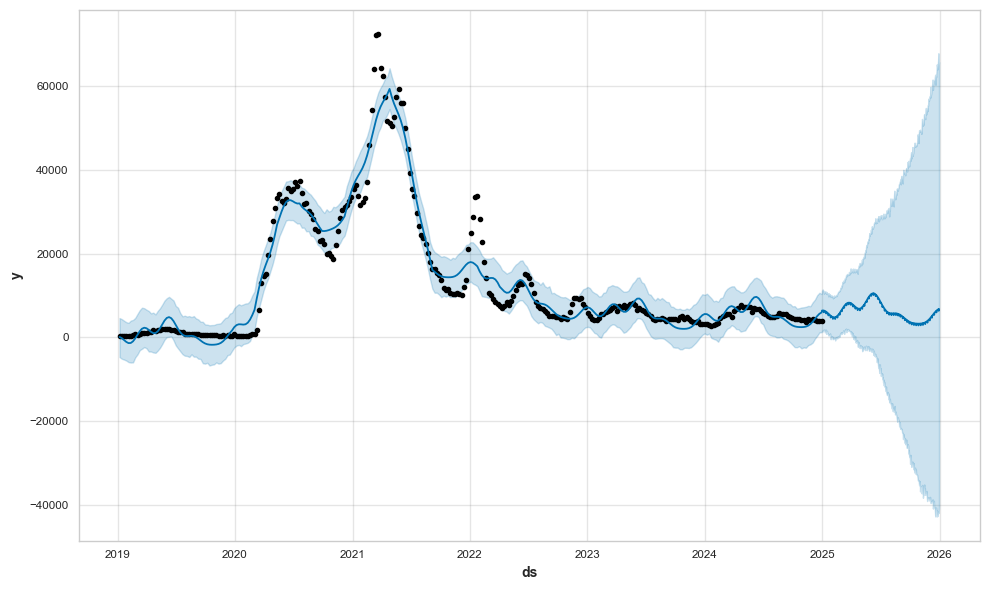

In [36]:
future = model.make_future_dataframe(periods=365)  # Prever 1 ano à frente
forecast = model.predict(future)

# Visualizar previsão
fig = model.plot(forecast)
plt.show()

In [37]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-07,81.857226,-4668.055262,4634.657824,81.857226,81.857226,37.583761,37.583761,37.583761,-355.659166,-355.659166,-355.659166,393.242926,393.242926,393.242926,0.0,0.0,0.0,119.440987
1,2019-01-14,117.268616,-5076.587797,4387.073502,117.268616,117.268616,-263.895666,-263.895666,-263.895666,-355.659166,-355.659166,-355.659166,91.763500,91.763500,91.763500,0.0,0.0,0.0,-146.627050
2,2019-01-21,152.680006,-5273.084264,4005.541979,152.680006,152.680006,-747.510385,-747.510385,-747.510385,-355.659166,-355.659166,-355.659166,-391.851219,-391.851219,-391.851219,0.0,0.0,0.0,-594.830379
3,2019-01-28,188.091395,-5509.512821,3660.850823,188.091395,188.091395,-1243.487333,-1243.487333,-1243.487333,-355.659166,-355.659166,-355.659166,-887.828167,-887.828167,-887.828167,0.0,0.0,0.0,-1055.395937
4,2019-02-04,223.502785,-5878.077852,3485.442209,223.502785,223.502785,-1567.245474,-1567.245474,-1567.245474,-355.659166,-355.659166,-355.659166,-1211.586308,-1211.586308,-1211.586308,0.0,0.0,0.0,-1343.742688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673,2025-12-26,6350.685475,-42491.949304,64904.028407,-42300.012434,64836.402909,294.727106,294.727106,294.727106,59.275810,59.275810,59.275810,235.451296,235.451296,235.451296,0.0,0.0,0.0,6645.412580
674,2025-12-27,6351.808327,-41587.013078,66051.854665,-42511.161774,65022.457468,341.902893,341.902893,341.902893,59.276714,59.276714,59.276714,282.626179,282.626179,282.626179,0.0,0.0,0.0,6693.711220
675,2025-12-28,6352.931180,-41705.247231,67855.751001,-42588.899247,65277.459895,383.169904,383.169904,383.169904,59.277680,59.277680,59.277680,323.892224,323.892224,323.892224,0.0,0.0,0.0,6736.101083
676,2025-12-29,6354.054032,-41898.495606,64972.751343,-42656.323717,65550.759655,3.400542,3.400542,3.400542,-355.659166,-355.659166,-355.659166,359.059708,359.059708,359.059708,0.0,0.0,0.0,6357.454574


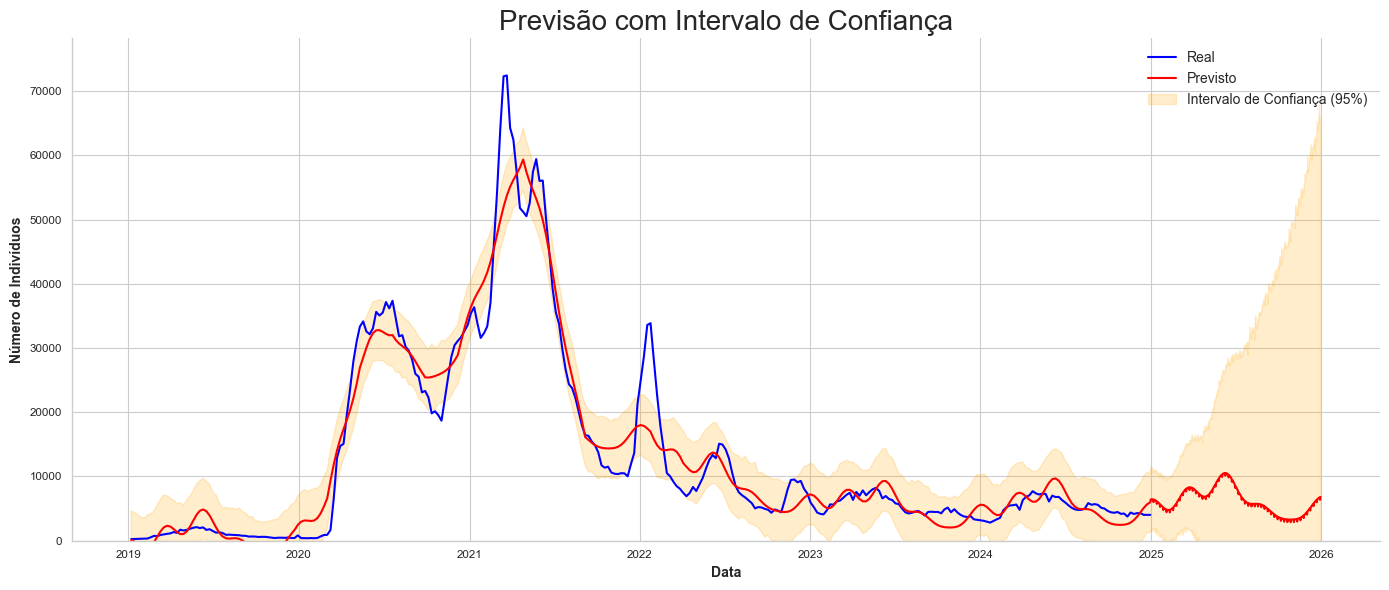

In [38]:
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Plotar dados reais
sns.lineplot(data=df, x='ds', y='y', label="Real", color='blue', linewidth=1.5)

# Plotar previsões (apenas positivas)
sns.lineplot(data=forecast, x='ds', y='yhat', label="Previsto", color='red', linewidth=1.5)

# Preencher intervalo de confiança (80% e 95%)
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='orange',
    alpha=0.2,
    label="Intervalo de Confiança (95%)"
)

# Mostrar apenas valores positivos no eixo y
plt.ylim(bottom=0)

plt.title("Previsão com Intervalo de Confiança", fontsize=20)
plt.xlabel("Data")
plt.ylabel("Número de Indivíduos")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

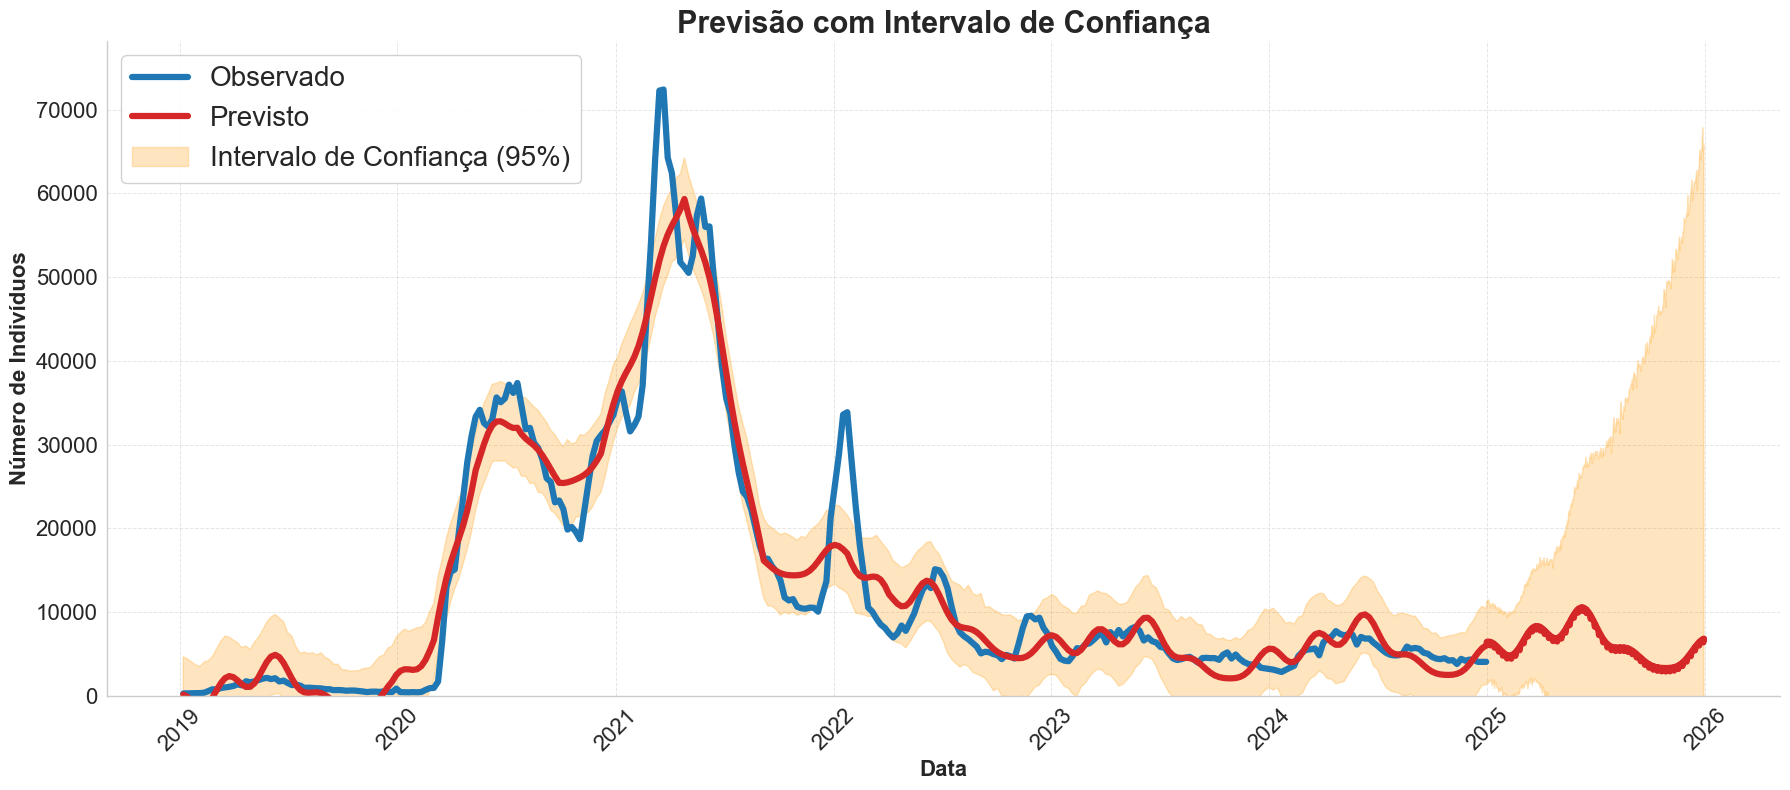

In [40]:
plt.figure(figsize=(18, 8))  # Aumentado o tamanho da figura

# Paleta de cores refinada
color_real = "#1f77b4"     # Azul
color_pred = "#d62728"     # Vermelho
color_ci = "#ff9900"       # Laranja

# Plotar dados reais
sns.lineplot(data=df, x='ds', y='y', label="Observado", color=color_real, linewidth=4.5)

# Plotar previsões
sns.lineplot(data=forecast, x='ds', y='yhat', label="Previsto", color=color_pred, linewidth=4.5)

# Preencher intervalo de confiança
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color=color_ci,
    alpha=0.25,
    label="Intervalo de Confiança (95%)"
)

# Ajustes de eixos e layout
plt.ylim(bottom=0)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Data", fontsize=16)
plt.ylabel("Número de Indivíduos", fontsize=16)
plt.title("Previsão com Intervalo de Confiança", fontsize=22, fontweight='bold')

# Legenda elegante
plt.legend(fontsize=20, loc="upper left", frameon=True, framealpha=0.9)

# Grade mais visível
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.5)

# Remover bordas
sns.despine()

# Layout ajustado
plt.tight_layout()
plt.show()

#### Outra abordagem: minimizar o MAPE

In [63]:
def objective_2(trial):
    # Hiperparâmetros a serem otimizados
    params = {
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
        'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 10),
        'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
        'yearly_seasonality': trial.suggest_int('yearly_seasonality', 5, 20),
        'weekly_seasonality': trial.suggest_int('weekly_seasonality', 3, 10),
    }
    
    # Criar e treinar o modelo
    model = Prophet(**params)
    model.fit(train_df)

        # Fazer previsão no conjunto de teste
    future = model.make_future_dataframe(periods=len(val_df))
    forecast = model.predict(future)
    
    # Calcular RMSE
    y_true = val_df['y'].values
    y_pred = forecast.tail(len(val_df))['yhat'].values
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return mape

In [64]:
study2 = optuna.create_study(direction='minimize')  # Queremos minimizar o RMSE
study2.optimize(objective_2, n_trials=200)  # Testar 50 combinações de parâmetros

# Melhores parâmetros encontrados
print("Melhores parâmetros:", study.best_params)

[I 2025-05-15 00:38:02,726] A new study created in memory with name: no-name-6895ffb8-dcc4-45d4-be3f-ac2da6002bd4
00:38:03 - cmdstanpy - INFO - Chain [1] start processing
00:38:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-15 00:38:04,181] Trial 0 finished with value: 1.0048331207320924 and parameters: {'changepoint_prior_scale': 0.015630013986664845, 'seasonality_prior_scale': 4.788191847262495, 'holidays_prior_scale': 9.404066140558003, 'seasonality_mode': 'additive', 'yearly_seasonality': 8, 'weekly_seasonality': 9}. Best is trial 0 with value: 1.0048331207320924.
00:38:04 - cmdstanpy - INFO - Chain [1] start processing
00:38:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-05-15 00:38:04,642] Trial 1 finished with value: 1.1407321374874249 and parameters: {'changepoint_prior_scale': 0.11044555904590397, 'seasonality_prior_scale': 5.0813393815204995, 'holidays_prior_scale': 2.7915184045830332, 'seasonality_mode': 'additive', 'yearly_seasonality': 16, 'weekly_

Melhores parâmetros: {'changepoint_prior_scale': 0.4663957084103698, 'seasonality_prior_scale': 1.2734388948371018, 'holidays_prior_scale': 7.160018639166438, 'seasonality_mode': 'additive', 'yearly_seasonality': 6, 'weekly_seasonality': 4}


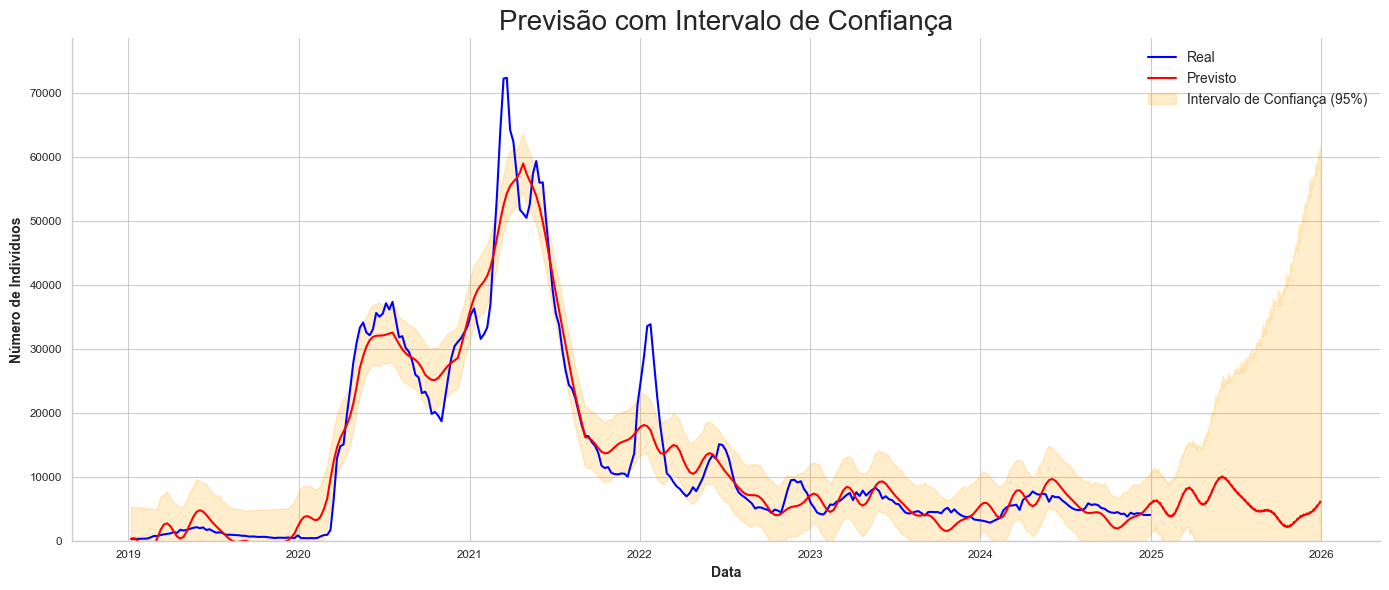

In [66]:
future2 = model.make_future_dataframe(periods=365)  # Prever 1 ano à frente
forecast2 = model.predict(future2)

plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# Plotar dados reais
sns.lineplot(data=df, x='ds', y='y', label="Real", color='blue', linewidth=1.5)

# Plotar previsões (apenas positivas)
sns.lineplot(data=forecast2, x='ds', y='yhat', label="Previsto", color='red', linewidth=1.5)

# Preencher intervalo de confiança (80% e 95%)
plt.fill_between(
    forecast_filtered['ds'],
    forecast_filtered['yhat_lower'],
    forecast_filtered['yhat_upper'],
    color='orange',
    alpha=0.2,
    label="Intervalo de Confiança (95%)"
)

# Mostrar apenas valores positivos no eixo y
plt.ylim(bottom=0)
plt.title("Previsão com Intervalo de Confiança", fontsize=20)
plt.xlabel("Data")
plt.ylabel("Número de Indivíduos")
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Filtrar apenas as datas de teste (onde temos valores reais para comparação)
forecast_test = forecast[forecast['ds'].isin(val_df['ds'])]
forecast_test = forecast_test[forecast_test['yhat'] > 0]  # Manter só previsões positivas

# Calcular RMSE e MAPE
rmse = np.sqrt(mean_squared_error(val_df['y'], forecast_test['yhat']))
mape = mean_absolute_percentage_error(val_df['y'], forecast_test['yhat']) * 100  # Em %

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 1636.44
MAPE: 30.23%
